## Residual-based Adaptive Refinement Learning for PyMacroFin 1D problem

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import Comparator, Constraint, System, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 200,
 "lr": 0.001,
 "loss_log_interval": 10,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-G"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.01, 0.99]

=====================================Agents=====================================

================================Agent

Total loss: 0.0019: 100%|██████████| 200/200 [00:04<00:00, 48.44it/s]


training finished, total time :: 4.137265205383301
Best model saved to ./models/BruSan14_log_utility/model_rarg_best.pt if valid
Model saved to ./models/BruSan14_log_utility/model_rarg.pt
Anchor points saved to ./models/BruSan14_log_utility/model_rarg_anchor_points.npy
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0004,
system_non-opt: 0.0000,
system_opt: 0.0004,
total_loss: 0.0008


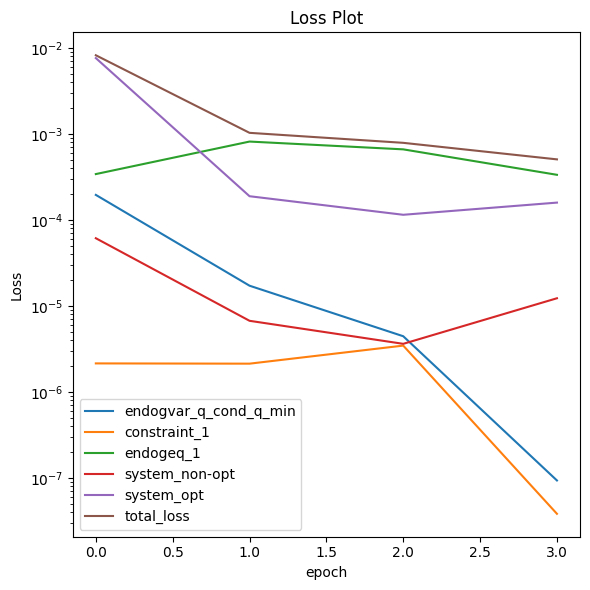

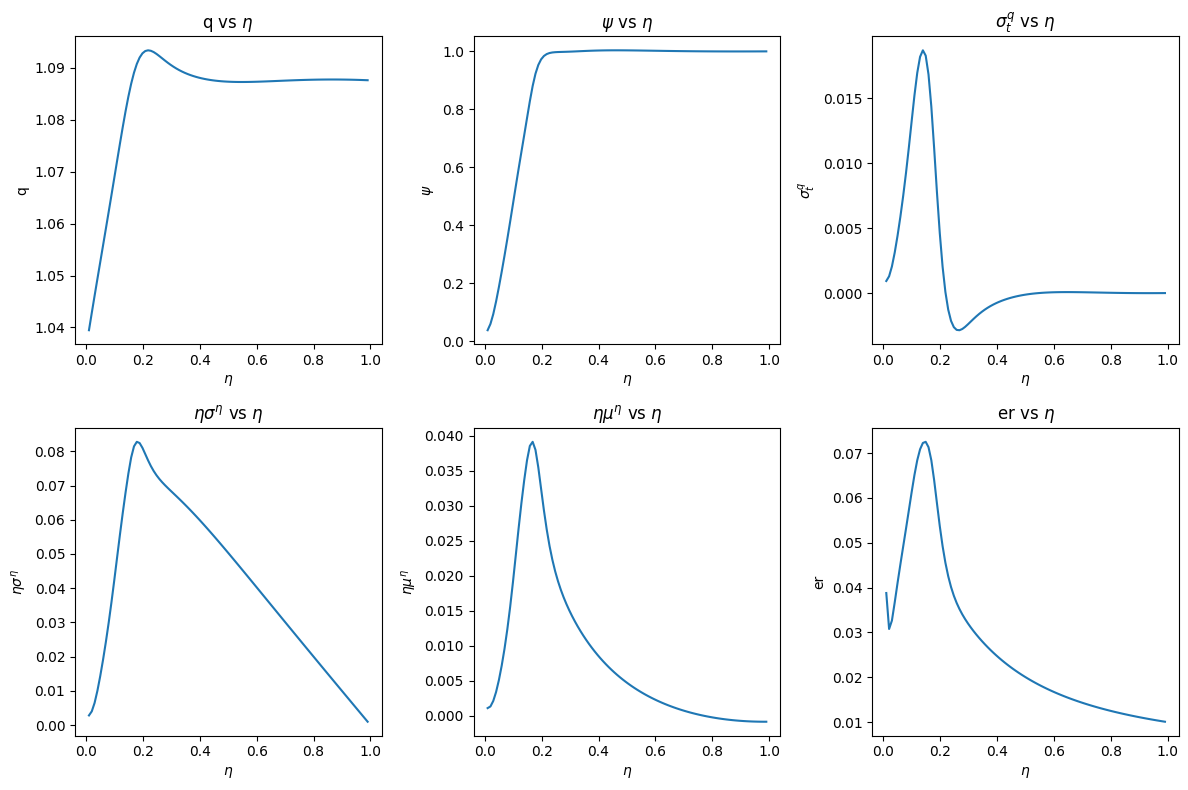

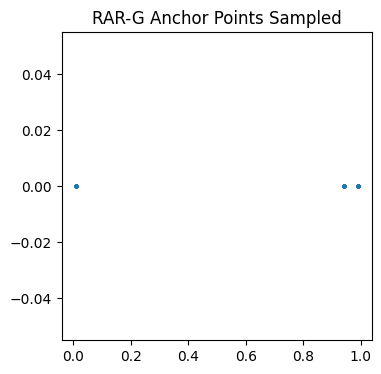

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", 
                     {"num_epochs": 200, "loss_log_interval": 10, "optimizer_type": OptimizerType.Adam,
                      "sampling_method": SamplingMethod.RARG}, 
                      latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")

sys1 = System([Constraint("psi", Comparator.LT, "1", "non-opt")], label="non-opt", latex_var_mapping=latex_var_mapping)
sys1.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")
sys2 = System([Constraint("psi", Comparator.GEQ, "1", "opt")], label="opt", latex_var_mapping=latex_var_mapping)
sys2.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$")
sys2.add_constraint("psi_e", Comparator.EQ, "0")
sys2.add_constraint("q_e", Comparator.LT, "0")
pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility/model_rarg.pt"):
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.set_state_constraints({"e": [0.01, 0.99]})
    pde_model.train_model("./models/BruSan14_log_utility", "model_rarg.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_rarg_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_rarg_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility/model_rarg_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility/model_rarg_min_loss.jpg")
pde_model.plot_vars(["q", r"$\psi$",
                     r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
anchor_points = np.load("./models/BruSan14_log_utility/model_rarg_anchor_points.npy").reshape(-1)
ax.scatter(anchor_points, np.zeros_like(anchor_points), s=4)
ax.set_title("RAR-G Anchor Points Sampled")
plt.show()

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 100,
 "num_epochs": 200,
 "lr": 0.001,
 "loss_log_interval": 10,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-D"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.01, 0.99]

=====================================Agents=====================================

================================Agent

Total loss: 0.0012: 100%|██████████| 200/200 [00:04<00:00, 46.63it/s]


training finished, total time :: 4.295850515365601
Best model saved to ./models/BruSan14_log_utility/model_rard_best.pt if valid
Model saved to ./models/BruSan14_log_utility/model_rard.pt
Anchor points saved to ./models/BruSan14_log_utility/model_rard_anchor_points.npy
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0005,
system_non-opt: 0.0000,
system_opt: 0.0001,
total_loss: 0.0007


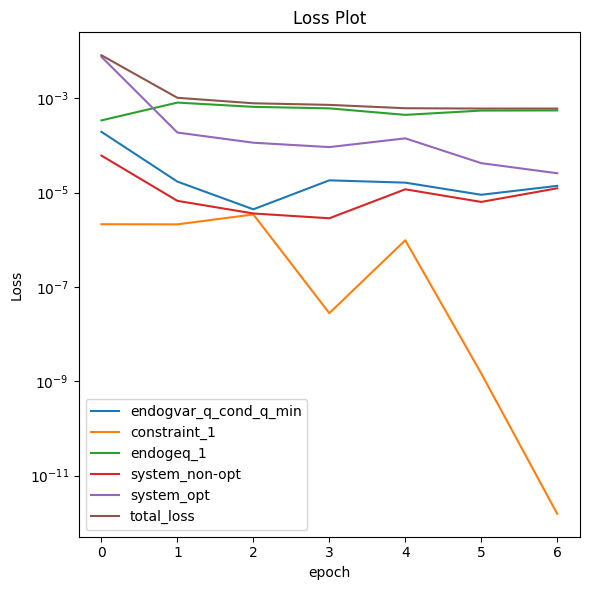

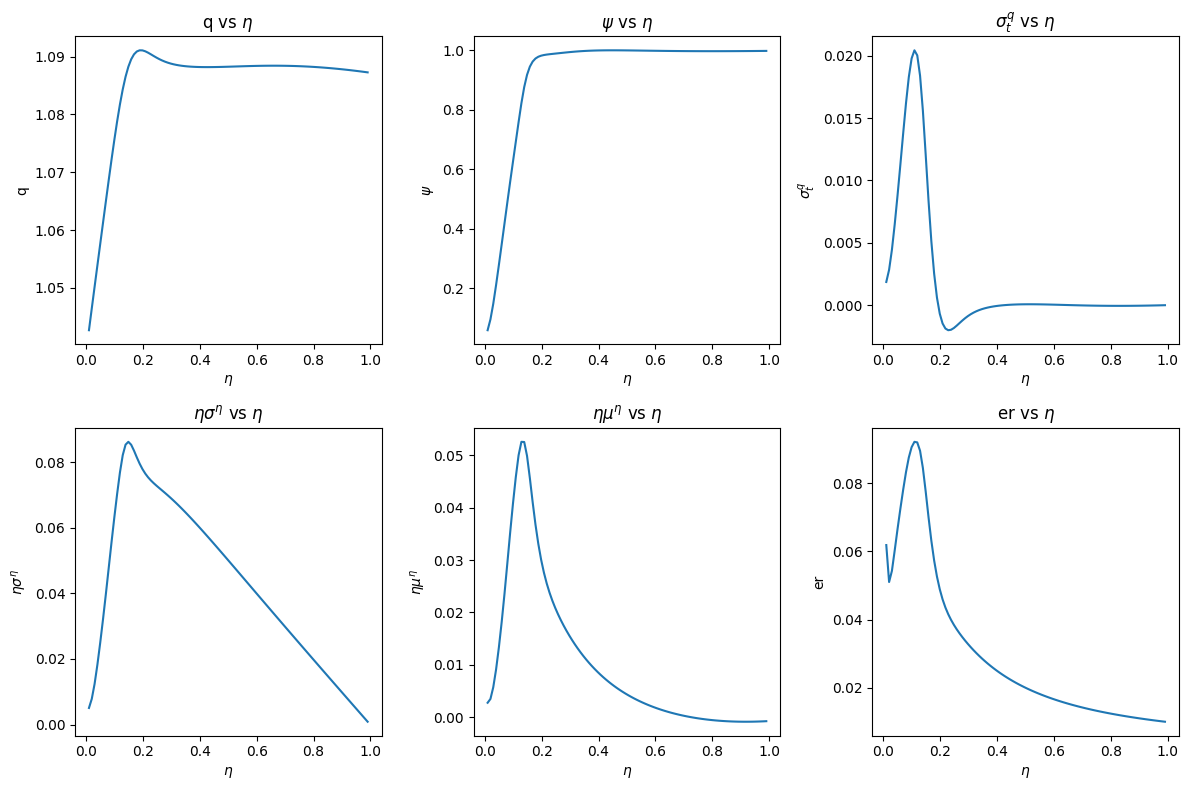

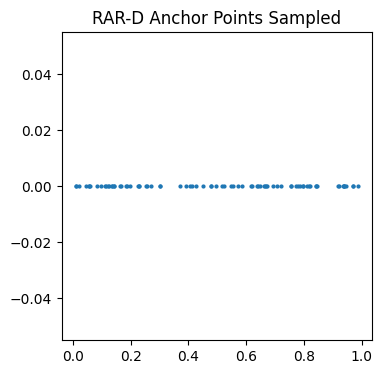

In [4]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", 
                     {"num_epochs": 200, "loss_log_interval": 10, "optimizer_type": OptimizerType.Adam,
                      "sampling_method": SamplingMethod.RARD}, 
                      latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "(2*ah*kappa + (kappa*r)**2 + 1)**0.5 - kappa*r", pde_model.variable_val_dict,
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")

sys1 = System([Constraint("psi", Comparator.LT, "1", "non-opt")], label="non-opt", latex_var_mapping=latex_var_mapping)
sys1.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")
sys2 = System([Constraint("psi", Comparator.GEQ, "1", "opt")], label="opt", latex_var_mapping=latex_var_mapping)
sys2.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$")
sys2.add_constraint("psi_e", Comparator.EQ, "0")
sys2.add_constraint("q_e", Comparator.LT, "0")
pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility/model_rard.pt"):
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_init_best.pt"))
    pde_model.set_state_constraints({"e": [0.01, 0.99]})
    pde_model.train_model("./models/BruSan14_log_utility", "model_rard.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_rard_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility/model_rard_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility/model_rard_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility/model_rard_min_loss.jpg")
pde_model.plot_vars(["q", r"$\psi$",
                     r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
anchor_points = np.load("./models/BruSan14_log_utility/model_rard_anchor_points.npy").reshape(-1)
ax.scatter(anchor_points, np.zeros_like(anchor_points), s=4)
ax.set_title("RAR-D Anchor Points Sampled")
plt.show()